# Experiment with TrOCR model

In [1]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

2023-04-23 20:01:10.353103: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 20:01:10.886935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 20:01:12.894917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Creating Easy to read Datasets from the IAM Handwritten Dataset

In [2]:
train_df = pd.read_fwf('trainset.txt', header=None)
train_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
print(len(train_df))
train_df.head()

53841


,file_name,text
0,IAMWords/a01/a01-000u/a01-000u-00-00.png,A
1,IAMWords/a01/a01-000u/a01-000u-00-01.png,MOVE
2,IAMWords/a01/a01-000u/a01-000u-00-02.png,to
3,IAMWords/a01/a01-000u/a01-000u-00-03.png,stop
4,IAMWords/a01/a01-000u/a01-000u-00-04.png,Mr.


In [3]:
test_df = pd.read_fwf('testset.txt', header=None)
test_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
print(len(test_df))
test_df.head()

17616


,file_name,text
0,IAMWords/m01/m01-049/m01-049-00-00.png,He
1,IAMWords/m01/m01-049/m01-049-00-01.png,rose
2,IAMWords/m01/m01-049/m01-049-00-02.png,from
3,IAMWords/m01/m01-049/m01-049-00-03.png,his
4,IAMWords/m01/m01-049/m01-049-00-04.png,breakfast-nook


In [4]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [5]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='',
                           df=train_df,
                           processor=processor)
test_dataset = IAMDataset(root_dir='',
                           df=test_df,
                           processor=processor)

In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 53841
Number of test examples: 17616


In [7]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [8]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [9]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

A


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [12]:
from tqdm.notebook import tqdm
for batch in tqdm(test_dataloader):
    # predict using generate
    pixel_values = batch["pixel_values"].to(device)
    print(pixel_values.shape)
    outputs = model.generate(pixel_values)
    print(outputs.shape)
    # decode
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    print(pred_str)
    labels = batch["labels"]
    print(labels.shape)
    labels[labels == -100] = processor.tokenizer.pad_token_id
    print(labels.shape)
    label_str = processor.batch_decode(labels, skip_special_tokens=True)
    print(label_str)
    break

  0%|          | 0/4404 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


torch.Size([4, 3, 384, 384])


/home/malhar/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


torch.Size([4, 4])
['he', 'joke', 'from', 'lis']
torch.Size([4, 128])
torch.Size([4, 128])
['He', 'rose', 'from', 'his']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 384, 384])


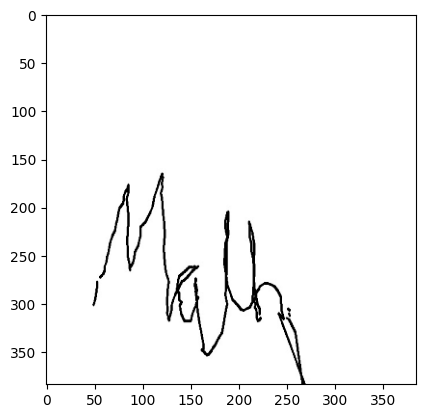

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/malhar/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


torch.Size([5])
['Maltz']


In [13]:
import matplotlib.pyplot as plt
# get file name + text 
file_name = 'Malh.jpg'
# prepare image (i.e. resize + normalize)
image = Image.open(file_name).convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)
# Convert pixel_values to a NumPy array
pixel_values_np = pixel_values.squeeze().numpy()
pixel_values_np = pixel_values_np.transpose(1, 2, 0)
# Display the pixel values using matplotlib
plt.imshow(pixel_values_np)
plt.show()
pred = model.generate(pixel_values.to(device))
print(pred.squeeze().shape)
stri = processor.batch_decode(pred, skip_special_tokens=True)
print(stri)